In [1]:
import os
os.chdir("../../")

In [26]:
try:
  import GPy
except ModuleNotFoundError:
  %pip install GPy
  import GPy

In [2]:

from flax import linen as nn
from flax.core import unfreeze
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import sin_data
from models.gaussian_mlp import gmlp 
from models.mlp import mlp 
from utilities.fits import fit
from utilities.gmm import gmm_mean_var
from utilities.predict import predict
import pandas as pd
# jax.config.update("jax_enable_x64", True)

In [3]:
from utilities import plot

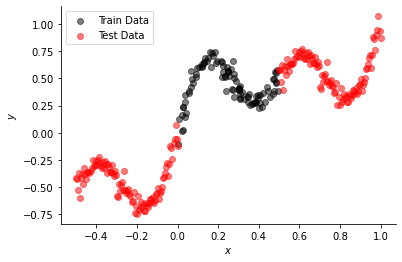

In [4]:
X,y,x_test_1,y_test_1,x_test_2,y_test_2 = sin_data.load_data()
x_stack =jnp.concatenate([x_test_1,X,x_test_2],axis=0)
y_stack = jnp.concatenate([y_test_1,y,y_test_2],axis=0)
plot.plot_actualdata(X,y,x_test_1,y_test_1,x_test_2,y_test_2)

In [5]:
data = pd.DataFrame()
data['X']  = X[:,0]
data['Y'] = y[:,0]
data = data.sort_values(by='X')
X_sorted = data['X'].values.reshape(100,1)
Y_sorted = data['Y'].values.reshape(100,1)


,X,Y
0,0.404683,0.348161
1,0.347803,0.285087
2,0.381339,0.270331
3,0.486767,0.552279
4,0.265132,0.590653


In [7]:
x_stack =jnp.concatenate([x_test_1,X_sorted,x_test_2],axis=0)
y_stack = jnp.concatenate([y_test_1,Y_sorted,y_test_2],axis=0)

## MLP

In [8]:
mlp_model = mlp([32, 32, 1],[nn.relu,nn.relu],[0,0])

In [9]:
mlp_params = mlp_model.init(jax.random.PRNGKey(0), X, True)

In [10]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [11]:
mlp_params, mlp_loss = fit(mlp_model, mlp_params, auxs, learning_rate= 0.01, epochs=2000, verbose=True)

Loss step 0:  0.12494419
Loss step 200:  0.0025141803
Loss step 400:  0.0020413701
Loss step 600:  0.0019541986
Loss step 800:  0.0019801876
Loss step 1000:  0.0019502228
Loss step 1200:  0.0019574196
Loss step 1400:  0.0019441455
Loss step 1600:  0.0019420319
Loss step 1800:  0.0019497558


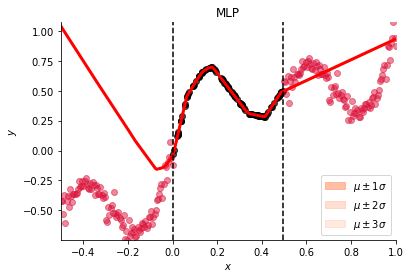

In [12]:
n_points =300
y_hat = mlp_model.apply(mlp_params, x_stack, True)
y_hat = y_hat.reshape(n_points)
y_hat_train = mlp_model.apply(mlp_params, X_sorted, True).reshape(100)
plot.plot_prediction(X_sorted,y_hat_train,x_stack,y_stack,y_hat,0,'MLP')

Gaussian MLP

In [13]:
gmlp_model = gmlp(features=[16,16], activations=[nn.relu, nn.relu], dropout_rate=[0.01, 0.01])

In [14]:
gmlp_params = gmlp_model.init(jax.random.PRNGKey(11), X, True)

In [15]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [16]:
gmlp_params, loss = fit(gmlp_model, gmlp_params, auxs,learning_rate=0.003, epochs=2000, verbose=False)

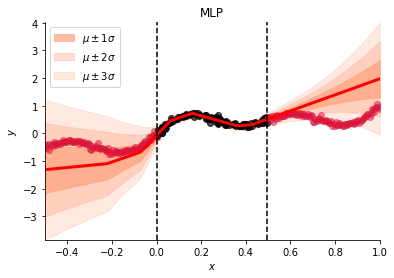

In [17]:
gmlp_mean, gmlp_sigma = gmlp_model.apply(gmlp_params, x_stack, True)
gmlp_mean , gmlp_sigma = gmlp_mean.reshape(n_points), gmlp_sigma.reshape(n_points)
plot.plot_prediction(X,y,x_stack,y_stack,gmlp_mean,gmlp_sigma,'MLP')

## MC Dropout Gaussian MLP

In [18]:
n_stacks = 100
fn = lambda i : gmlp_model.apply(gmlp_params, x_stack, deterministic=False, rngs={"dropout": jax.random.PRNGKey(i)})
y_stacks = jax.vmap(fn, in_axes=(0))(jnp.arange(n_stacks))
mean_stacks = y_stacks[0]
sigma_stacks = y_stacks[1]

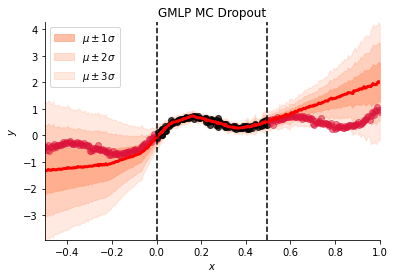

In [19]:
mc_mean, mc_sigma = gmm_mean_var(mean_stacks, sigma_stacks)
mc_mean, mc_sigma= mc_mean.reshape(n_points),mc_sigma.reshape(n_points)
plot.plot_prediction(X,y,x_stack,y_stack,mc_mean,mc_sigma,'GMLP MC Dropout')

## Deep Ensemble Gaussian MLP

In [20]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [21]:
params_list = []
losses_list = []
n_models = 5

for i in range(5):
    params = gmlp_model.init(jax.random.PRNGKey(i), auxs['X'], deterministic = True)
    params, loss =  fit(gmlp_model, params, auxs, learning_rate=0.003, epochs=2000, verbose=False)
    params_list.append(params)
    losses_list.append(loss)


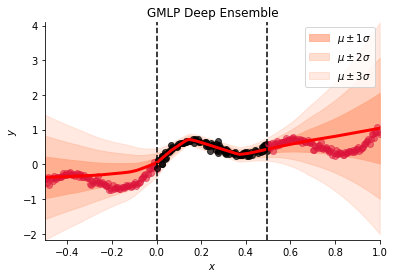

In [22]:
means_list,sigmas_list = predict(n_models, gmlp_model, params_list, x_stack)
de_mean, de_sigma = gmm_mean_var(means_list,sigmas_list)
de_mean, de_sigma = de_mean.reshape(n_points),de_sigma.reshape(n_points)
plot.plot_prediction(X,y,x_stack,y_stack,de_mean,de_sigma,'GMLP Deep Ensemble')

## GP

In [28]:
key = jax.random.PRNGKey(42)
sigmaf = 1.0
len_scale =  1.0
kernel = GPy.kern.RBF(1, sigmaf, len_scale)



In [32]:
%%capture
model_gp = GPy.models.GPRegression(X, y, kernel, normalizer=False) 
model_gp.Gaussian_noise = 1.0
model_gp.optimize(messages=True)
model_gp.optimize_restarts(num_restarts=5)

In [34]:
%%capture
mu_gp, cov_gp = model_gp.predict(x_stack)
mu_gp=mu_gp.reshape(n_points)
sigma_gp= jnp.sqrt(cov_gp).reshape(n_points)

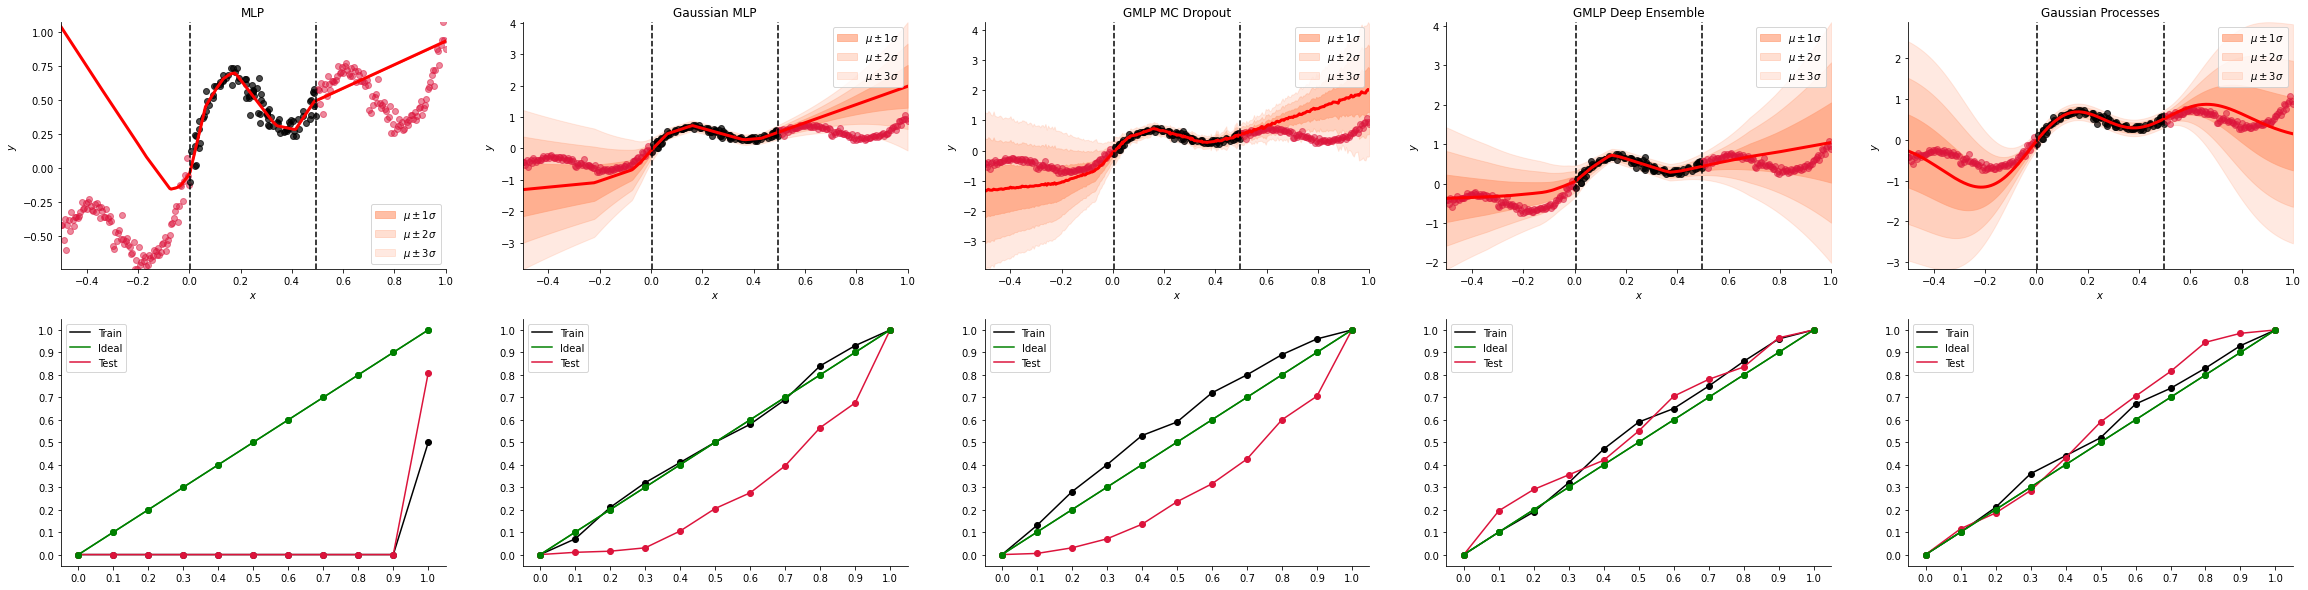

In [36]:
fig, ax = plt.subplots(2, 5, figsize=(40, 10))
plot.plot_prediction(X,y,x_stack,y_stack,y_hat,0,'MLP',ax[0][0])
plot.plot_prediction(X,y,x_stack,y_stack,gmlp_mean,gmlp_sigma,'Gaussian MLP',ax[0][1])
plot.plot_prediction(X,y,x_stack,y_stack,mc_mean,mc_sigma,'GMLP MC Dropout',ax[0][2])
plot.plot_prediction(X,y,x_stack,y_stack,de_mean,de_sigma,'GMLP Deep Ensemble',ax[0][3])
plot.plot_prediction(X,y,x_stack,y_stack,mu_gp,sigma_gp,'Gaussian Processes',ax[0][4])
plot.calibration_reg(y_hat,jnp.zeros(300),y_stack,ax[1][0])
plot.calibration_reg(gmlp_mean,gmlp_sigma,y_stack,ax[1][1])
plot.calibration_reg(mc_mean,mc_sigma,y_stack,ax[1][2])
plot.calibration_reg(de_mean,de_sigma,y_stack,ax[1][3])
plot.calibration_reg(mu_gp,sigma_gp,y_stack,ax[1][4])



## GP

In [ ]:
key = jax.random.PRNGKey(42)